## Importing Packages

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns

import xgboost

from PIL import Image

from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              GradientBoostingClassifier, RandomForestClassifier,
                              StackingClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             auc, classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                   train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from wordcloud import WordCloud

## Importing Data & EDA

In [2]:
#Importing dataset
df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
df['label'].value_counts(normalize=True)

label
CG    0.5
OR    0.5
Name: proportion, dtype: float64

There we can see that we have a perfectly balanced dataset as far as our target.

In [4]:
df['category'].value_counts()

category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64

In [5]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [6]:
# Creating 'target' Column for Classification
df['target'] = np.where(df['label'] == 'CG', 1, 0)

### Distribution of categories by rating

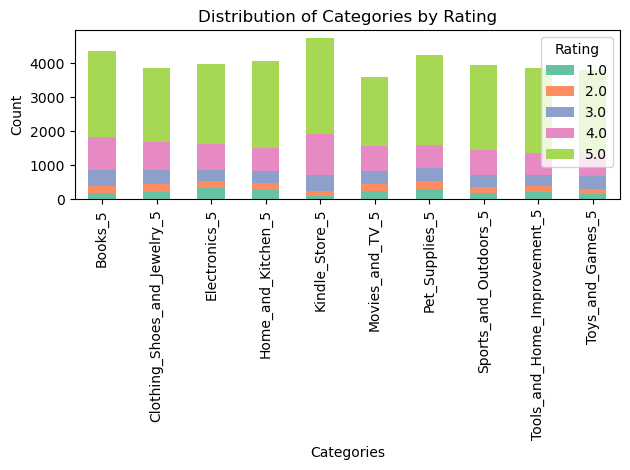

In [7]:
# Bar Chart for Distribution of Categories by Rating
sns.set_palette("Set2")

df_grouped = df.groupby(['category', 'rating']).size().unstack(fill_value=0)
ax = df_grouped.plot(kind='bar', stacked=True)

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Categories by Rating')
plt.xticks(rotation=90)
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

Some categories, such as "Books" and "Kindle Store," have a more substantial proportion of highly positive reviews (5.0), while others like "Electronics" and "Pet Supplies" have a relatively higher number of reviews with lower ratings (1.0, 2.0, and 3.0).

<Figure size 1200x600 with 0 Axes>

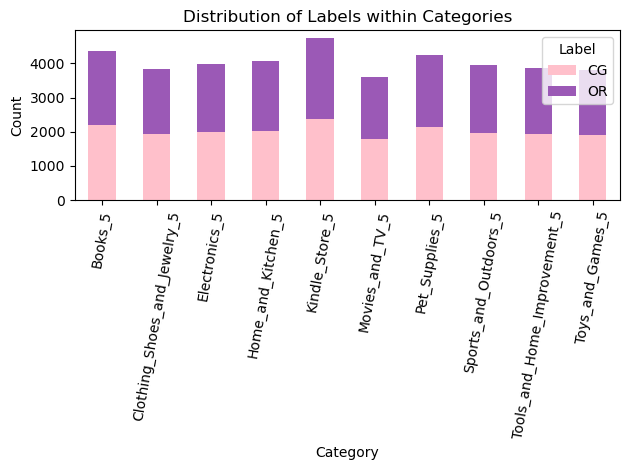

In [8]:
#Bar Chart for Distribution of Labels within Categories
plt.figure(figsize=(12, 6))
label_category_counts = df.groupby(['category', 'label']).size().unstack(fill_value=0)
label_category_counts.plot(kind='bar', stacked=True, color=['pink', '#9B59B6'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Labels within Categories')
plt.xticks(rotation=80)
plt.legend(title='Label')
plt.tight_layout()
#plt.show();

-  The table shows an equal distribution of the "CG" and "OR" labels within each category. 

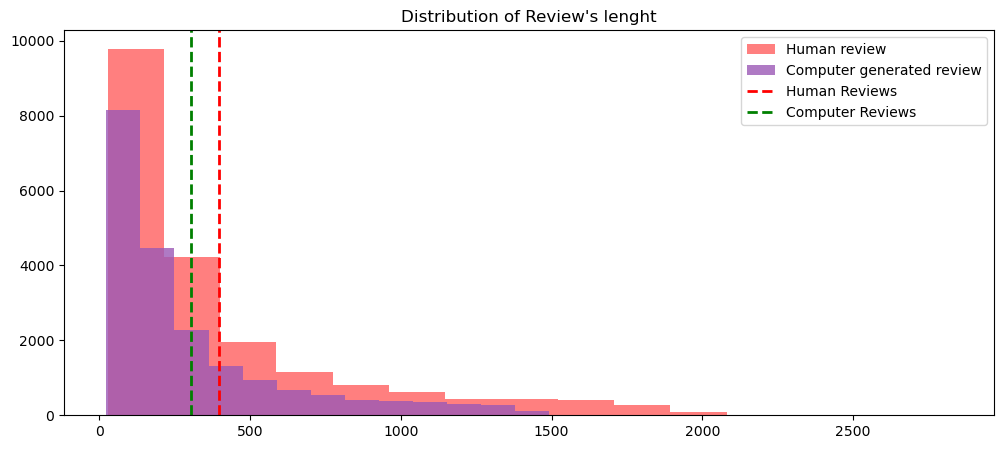

In [9]:
comp_gen = df[df['target'] == 1]
human_gen = df[df['target'] ==0]

fig, ax = plt.subplots(figsize=(12,5))
ax1 = plt.hist(human_gen['text_'].str.len(), bins=15, color='r', label='Human review', alpha=0.5)
ax2 = plt.hist(comp_gen['text_'].str.len(), bins=15, color= '#9B59B6', label='Computer generated review', alpha=0.8)
plt.axvline(human_gen['text_'].str.len().mean(), color='red', linestyle='dashed', linewidth=2, label='Human Reviews')
plt.axvline(comp_gen['text_'].str.len().mean(), color='green', linestyle='dashed', linewidth=2, label='Computer Reviews')
plt.title("Distribution of Review's lenght")
plt.legend();

We can see here that the human generated reviews tends to be larger than the computer generated.

Let's look now at the word count and evaluate their count

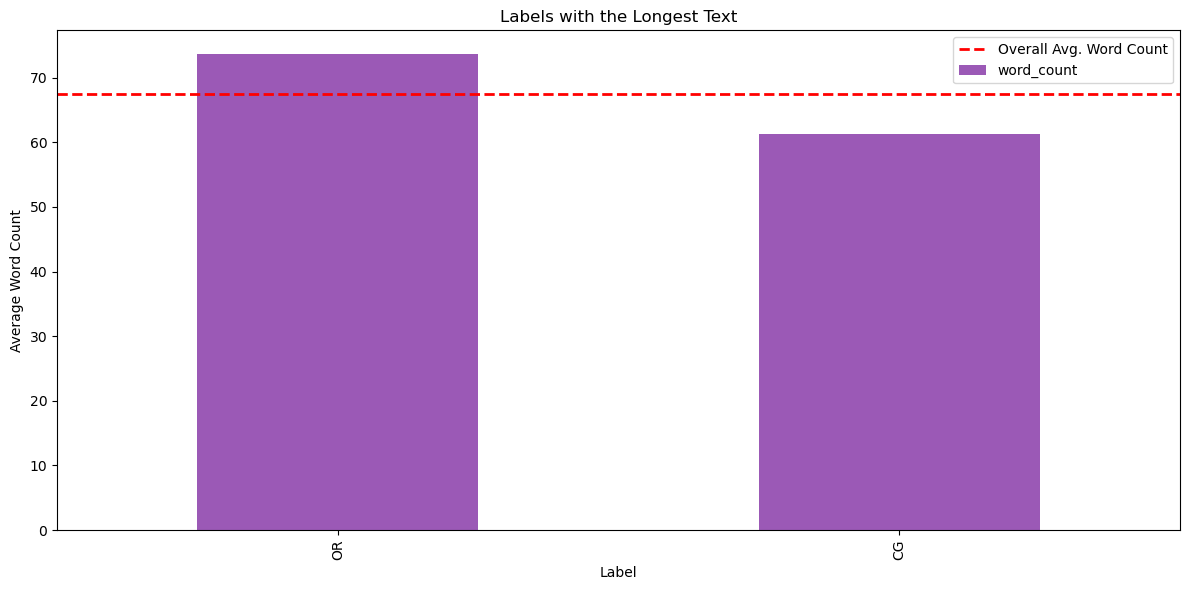

In [10]:
# Calculating Word Count for each review
df['word_count'] = df['text_'].apply(lambda x: len(x.split()))

# Calculating Average Word Count by Label
label_word_counts = df.groupby('label')['word_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_word_counts.plot(kind='bar', color='#9B59B6') 
plt.xlabel('Label')
plt.ylabel('Average Word Count')
plt.title('Labels with the Longest Text')
plt.xticks(rotation=90)
plt.axhline(df['word_count'].mean(), color='red', linestyle='dashed', linewidth=2, label='Overall Avg. Word Count')
plt.legend()
plt.tight_layout()

plt.show()

On average, reviews with the "OR" label have a higher word count compared to reviews labeled as "CG." The mean word count for "OR" reviews is approximately 73.64 words, while the mean word count for "CG" reviews is lower at around 61.29 words.

In [11]:
# Examining the count of reviews by rating and label
label_rating_counts = df.groupby(['label', 'rating']).size().unstack(fill_value=0)
label_rating_counts

rating,1.0,2.0,3.0,4.0,5.0
label,,,,,
CG,1063,962,1952,3920,12319
OR,1092,1005,1834,4045,12240


<Figure size 1200x600 with 0 Axes>

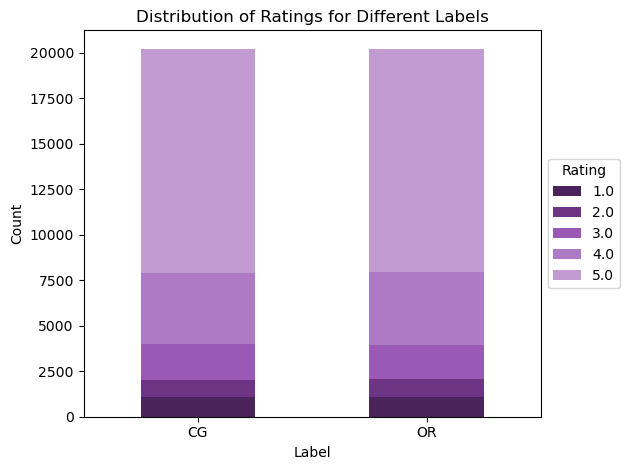

In [12]:
# Distribution of Ratings for Different Labels
custom_purple_palette = ['#C39BD3', '#AF7AC5', '#9B59B6', '#6C3483', '#4A235A']

plt.figure(figsize=(12, 6))
label_rating_counts.plot(kind='bar', stacked=True, color=custom_purple_palette[::-1])  # Reverse the color palette

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Ratings for Different Labels')
plt.xticks(rotation=0)
plt.legend(title='Rating', labels=label_rating_counts.columns, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show();

- Both "CG" and "OR" labels exhibit a relatively balanced distribution of ratings. While both labels have a similar distribution of ratings, the "CG" label appears to have slightly fewer reviews with 4.0 and 5.0 ratings compared to the "OR" label. Across both labels, positive ratings (4.0 and 5.0) significantly outnumber negative ratings (1.0 and 2.0).

In [13]:
label_category_counts = df.groupby(['label', 'category']).size().unstack(fill_value=0)
label_category_counts

category,Books_5,Clothing_Shoes_and_Jewelry_5,Electronics_5,Home_and_Kitchen_5,Kindle_Store_5,Movies_and_TV_5,Pet_Supplies_5,Sports_and_Outdoors_5,Tools_and_Home_Improvement_5,Toys_and_Games_5
label,,,,,,,,,,
CG,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897
OR,2185,1924,1994,2028,2365,1794,2127,1973,1929,1897


### Word Cloud for Label column

In [14]:
# Filtering Data for 'CG' and 'OR' Labels
df_cg = df[df['label'] == 'CG']  
df_or = df[df['label'] == 'OR']

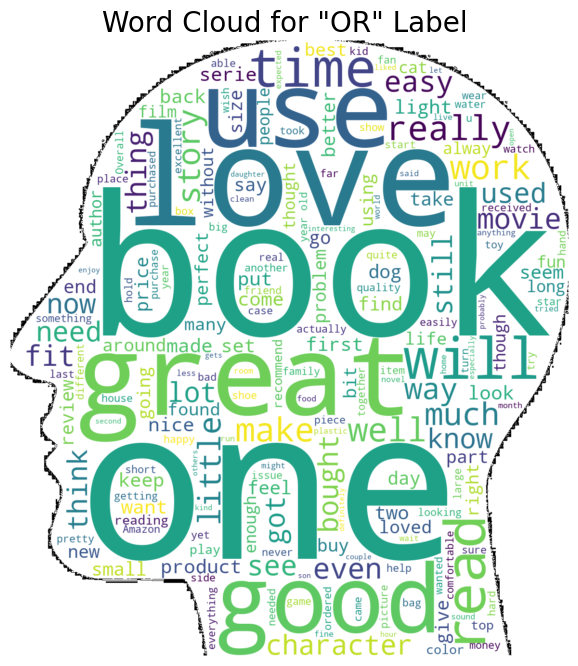

In [15]:
# Word Cloud for 'OR' Label Using a Custom Mask
face_mask = np.array(Image.open('/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/face_picture.jpeg'))
text_corpus = " ".join(df_or['text_'])

wordcloud = WordCloud(
    width=600,
    height=600,
    background_color='white',
    mask=face_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "OR" Label ', fontsize=20)
plt.show()

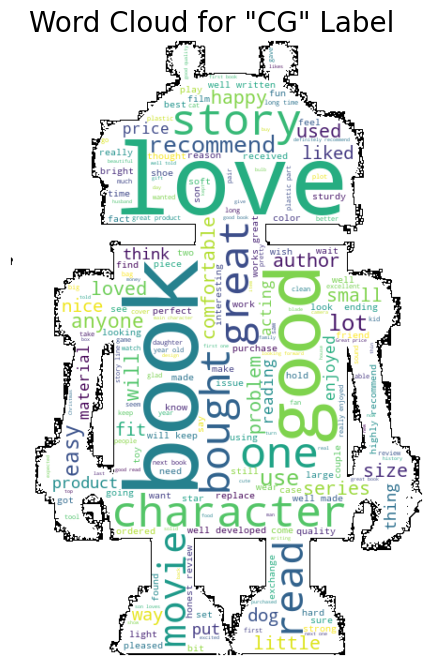

In [16]:
# Word Cloud for 'CG' Label Using a Custom Mask
robot_mask = np.array(Image.open('/Users/katyaserbina/Documents/Flatiron/Project 4/NLP-Review-Detector/Ekaterina/SIlhouette.png'))
text_corpus_2 = " ".join(df_cg['text_'])

wordcloud = WordCloud(
    width=800,
    height=800,
    background_color='white',
    mask=robot_mask,
    contour_color='black',  
    contour_width=1,
).generate(text_corpus_2)


plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "CG" Label ', fontsize=20)
plt.show()

# Data Preprocessing

## Text Preprocessing: Tokenization & Lemmantization

One of the most important things to do when preprocessing language data is to tokenize them, and apply either lemmantizing or stemming.

We decided to go for stemming since is richer, and in order to avoid data leakage we created functions for all the preprocessing to apply in the train and test data once we split it

In [17]:
# Defining Tokenizer function

def tokenizer(x):
    
    corpus = [word_tokenize(doc) for doc in x]

# Getting common stop words in english that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')
    corpus_no_stopwords = []
    for words in corpus:
        docs = [x.lower() for x in words if ((x.isalpha()) & (x not in stop_words))]
        corpus_no_stopwords.append(docs)
    return corpus_no_stopwords

# Defining Lemmatizer function, we can decide with the parameter "as_string" if we want to have the result tokenized or join

def lemmatizer(corpus, as_string=True):
    lem = WordNetLemmatizer()
# Defining an inner function 'pos_tagger'    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
    lemmatized_corpus = []
    for sentence in corpus:
        pos_tags = pos_tag(sentence)
        lemmatized_sentence = []
        for word, tag in pos_tags:
            pos = pos_tagger(tag)
            if pos is not None:
                lemmatized_word = lem.lemmatize(word, pos)
            else:
                lemmatized_word = lem.lemmatize(word)
            lemmatized_sentence.append(lemmatized_word)
        lemmatized_corpus.append(lemmatized_sentence)
    if as_string:
        lemmatized_corpus  = [' '.join(x) for x in lemmatized_corpus]
    return lemmatized_corpus
    
# After processing all words in the sentence, the lemmatized_sentence is added to the lemmatized_corpus
        

### Splitting Data into Training and Testing Sets

In [18]:
# Dividing train and test data, setting 30% for test

X_train, X_test, y_train,y_test = train_test_split(df['text_'],df['target'], test_size=0.3,random_state=42)

# Preprocessing both Train and Test Data
X_train_preprocessed = lemmatizer(tokenizer(X_train))
X_test_preprocessed = lemmatizer(tokenizer(X_test))

## Baseline model testing two different vectorizers

The next step in our preprocessing is to vectorize the sentences, to do that we need to choose either Count Vectorizer and TF-IDF Vectorizer, to decide we'll run a Logistic Regression and a Random Forest with the data preprocessed in both ways to compare.

To account for the overfitting of Random Forest without any type of hyperparameter tuning, we'll apply cross validationt to these models.

Since we have balanced data, and there's not significant difference between having false negatives and false positives, we decided to use accuracy as a metric

### Random Forest and Logistic Regression with the Count Vectorizer

In [19]:
# Train and Evaluate Random Forest Model with CountVectorizer

steps = [('countvec',CountVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200,random_state=42))]
pipe_cv_rf = Pipeline(steps)
pipe_cv_rf.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Random Forest Model with CountVectorizer
crossval_rf_cv = np.mean(cross_val_score(pipe_cv_rf, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_rf_cv

0.7627021346850904

In [22]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate predictions on the validation set
y_pred = pipe_cv_rf.predict(X_val_preprocessed)

# Create a confusion matrix
confusion = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", confusion)

# Plot the confusion matrix
plot_confusion_matrix(pipe_cv_rf, X_val_preprocessed, y_val, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculate ROC curve and AUC
y_pred_prob = pipe_cv_rf.predict_proba(X_val_preprocessed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

In [20]:
# Train and Evaluate Logistic Regression Model with CountVectorizer
steps[1] = ('logreg',LogisticRegression(random_state=42))
pipe_cv_lr = Pipeline(steps)
pipe_cv_lr.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Logistic Regression Model with CountVectorizer
crossval_lr_cv = np.mean(cross_val_score(pipe_cv_lr, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_lr_cv

0.7266269054338063

In [ ]:
# Generate predictions on the validation set
y_pred_lr = pipe_cv_lr.predict(X_val_preprocessed)

# Create a confusion matrix
confusion_lr = confusion_matrix(y_val, y_pred_lr)
print("Confusion Matrix for Logistic Regression:\n", confusion_lr)

# Plot the confusion matrix
plot_confusion_matrix(pipe_cv_lr, X_val_preprocessed, y_val, cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Calculate ROC curve and AUC for Logistic Regression
y_pred_prob_lr = pipe_cv_lr.predict_proba(X_val_preprocessed)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_val, y_pred_prob_lr)
roc_auc_lr = roc_auc_score(y_val, y_pred_prob_lr)

# Plot ROC curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


### Random Forest and Logistic Regression with the TF-IDF Vectorizer

In [21]:
# Train and Evaluate Random Forest Model with TfidfVectorizer
steps = [('tfidfvec',TfidfVectorizer(min_df = 0.05, max_df = 0.95)),('rfc',RandomForestClassifier(n_estimators=200,random_state=42))]
pipe_idf_rf = Pipeline(steps)
pipe_idf_rf.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Random Forest Model with TfidfVectorizer
crossval_rf_idf = np.mean(cross_val_score(pipe_idf_rf, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_rf_idf

0.7631969029932032

In [22]:
# Train and Evaluate Logistic Regression Model with TfidfVectorizer
steps[1] = ('logreg',LogisticRegression(random_state=42))
pipe_idf_lr = Pipeline(steps)
pipe_idf_lr.fit(X_train_preprocessed, y_train)

# Calculating Mean Cross-Validation Score for Logistic Regression Model with TfidfVectorizer
crossval_lr_idf = np.mean(cross_val_score(pipe_idf_lr, X_train_preprocessed,y_train,scoring='accuracy',cv=5))

crossval_lr_idf

0.7267683043675561

After evaluating the models with both types of vectorizers, we decided to choose the count vectorizer for further analysis

In [8]:
# Instantiating the Count Vectorizer and applying it to both train and test data

vectorizer = CountVectorizer(min_df=0.05,max_df=0.95)

X_train_vec = vectorizer.fit_transform(X_train_preprocessed)
X_test_vec = vectorizer.transform(X_test_preprocessed)

## Hyper Parameter Tuning

### Parameter Grids

Defining parameter grids for all of the models we will try

In [24]:
# Defining Hyperparameter Grids for Random Forest and Logistic Regression Models
param_grid_random_forest = {'n_estimators':[100,150,200],
                       'max_depth':[2,3,4,5],
                       'min_samples_leaf':[1,2,3]
                      }

param_grid_logistic_regression = {'penalty':['l1', 'l2', 'elasticnet', None],
                 'C':[0.001,0.01,0.1,1,10,100],
                 'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
                }

param_grid_ada = {'n_estimators':[50,100,150,200],
                  'learning_rate':[0.01,0.1,0.2,0.5,1]
                 }

param_grid_gradient = {'n_estimators':[50,100,150,200],
                       'learning_rate':[0.01,0.1,0.2,0.5,1],
                       'max_depth':[1,2,3,4]
                      }

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2]
}

### Hyperparameter Tuning with GridSearchCV

In [25]:
# Applying GridSearchCV on different models to get the best set of hyper-parameters for each one

gs_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,random_state=42), param_grid=param_grid_random_forest,scoring='accuracy',cv=5,error_score=0)
gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42,max_iter=10000), param_grid=param_grid_logistic_regression,scoring='accuracy',cv=5,error_score=0)
gs_ada = GridSearchCV(estimator=AdaBoostClassifier(random_state=42), param_grid=param_grid_ada,scoring='accuracy',cv=5,error_score=0)
gs_gradient = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid_gradient,scoring='accuracy',cv=5,error_score=0)
gs_xgb = GridSearchCV(estimator=xgboost.XGBClassifier(random_state=42, objective='binary:logistic'), param_grid=param_grid_xgb,scoring='accuracy',cv=5,error_score=0)

In [26]:
# Fitting each GridSearch object with out training data

gs_rf.fit(X_train_vec,y_train)
gs_lr.fit(X_train_vec,y_train)
gs_ada.fit(X_train_vec,y_train)
gs_gradient.fit(X_train_vec,y_train)
gs_xgb.fit(X_train_vec,y_train)

GridSearchCV(cv=5, error_score=0,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learn...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [27]:
# Best Hyperparameters for Random Forest Model
best_random_forest = gs_rf.best_estimator_
best_logistic_regression = gs_lr.best_estimator_
best_ada_boost = gs_ada.best_estimator_
best_gradient = gs_gradient.best_estimator_
best_xgboost = gs_xgb.best_estimator_

In [28]:
# Score for the Random Forest Model with best hyper parameters
gs_rf.best_score_

0.7006221915118195

In [29]:
# Score for the Logistic Regression Model with best hyper parameters
gs_lr.best_score_

0.7277222181649535

In [30]:
# Score for the Ada Booster Model with best hyper parameters
gs_ada.best_score_

0.7383930532070212

In [31]:
# Score for the Gradient Booster Model with best hyper parameters
gs_gradient.best_score_

0.7741148506644245

In [32]:
# Score for the XGBoost Model with best hyper parameters
gs_xgb.best_score_

0.7775068208928113

## Best XGBoost Estimator and Bagging

In [33]:
# Bagging with XGBoost Classifier
bagging = BaggingClassifier(estimator=best_xgboost, n_estimators=100)

crossval_xgb_bagging = np.mean(cross_val_score(bagging, X_train_vec, y_train, scoring='accuracy', cv=5))
crossval_xgb_bagging

0.7797682425722334

### Averaging the Models

In [34]:
avg = VotingClassifier(estimators=[
    ('lr', best_logistic_regression),
    ('rf', best_random_forest),
    ('xgb', best_xgboost),
    ('ada', best_ada_boost),
    ('gradient', best_gradient)])
avg.fit(X_train_vec, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.1, max_iter=10000,
                                                 random_state=42,
                                                 solver='newton-cg')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=F...
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 n_estimators=200,
                                                 random_state=42)),
                             ('gradient',
                              GradientBoostingClassifier(learning_rate=0.5,
                                                         max_depth=4,
                                                         n_estimators=200,
                                                         random_state=42))])

In [35]:
cross_val_voting = np.mean(cross_val_score(avg,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_voting

0.7591689153297967

### Weighted Averaging with the VotingClassifier

In [36]:
w_avg = VotingClassifier(estimators=[
    ('lr', best_logistic_regression),
    ('rf', best_random_forest),
    ('xgb', best_xgboost),
    ('ada', best_ada_boost),
    ('gradient', best_gradient)],
                        weights=[0.05, 0.05, 0.5, 0.2, 0.2])
w_avg.fit(X_train_vec, y_train)

cross_val_weighted_voting = np.mean(cross_val_score(w_avg,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_weighted_voting

0.7767648213584609

- We assigned a weight of 0 to 'lr' and 'rf' because their scores are too low compared to the other estimators


### Stacking

In [37]:
# Stacking Classifier
estimators = [
    ('bag',bagging),
    ('xgb', best_xgboost),
    ('gradient', best_gradient),
    ('ada', best_ada_boost)
    
]
# Stacking Classifier Cross-Validation
sr = StackingClassifier(estimators).fit(X_train_vec,y_train)
cross_val_stacking = np.mean(cross_val_score(sr,X_train_vec,y_train,scoring='accuracy', cv=5))
cross_val_stacking

0.7799449584691738

### Shallow neural network

In [48]:
baseline_nn = Sequential()
baseline_nn.add(Dense(50, input_dim=91, activation='relu'))
baseline_nn.add(Dense(units=1, activation='sigmoid'))
baseline_nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
history = baseline_nn.fit(X_train_vec.toarray(), y_train, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
708/708 [==============================] - 1s 1ms/step - loss: 0.5515 - accuracy: 0.7067 - val_loss: 0.5118 - val_accuracy: 0.7373
Epoch 2/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4983 - accuracy: 0.7462 - val_loss: 0.4948 - val_accuracy: 0.7543
Epoch 3/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4769 - accuracy: 0.7613 - val_loss: 0.4850 - val_accuracy: 0.7605
Epoch 4/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4597 - accuracy: 0.7702 - val_loss: 0.4742 - val_accuracy: 0.7665
Epoch 5/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4458 - accuracy: 0.7799 - val_loss: 0.4652 - val_accuracy: 0.7689
Epoch 6/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4344 - accuracy: 0.7853 - val_loss: 0.4619 - val_accuracy: 0.7727
Epoch 7/100
708/708 [==============================] - 1s 1ms/step - loss: 0.4257 - accuracy: 0.7913 - val_loss: 0.4585 - val_accuracy: 0.7742

With an accuracy of 0.877 and a validation accuracy of 0.745 we can safely say that is overfitting, now, let's try to improve our model

In [49]:
baseline_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50)                4600      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 4,651
Trainable params: 4,651
Non-trainable params: 0
_________________________________________________________________


In [52]:
y_hat_proba = baseline_nn.predict(X_train_vec.toarray())

885/885 [==============================] - 1s 707us/step


In [54]:
y_hat_train = (y_hat_proba > 0.5).astype('int')
accuracy_score(y_train, y_hat_train)

0.8552045791816832

In [55]:
_, train_accuracy = baseline_nn.evaluate(X_train_vec.toarray(), y_train, verbose=1)
print(train_accuracy)

885/885 [==============================] - 1s 883us/step - loss: 0.3466 - accuracy: 0.8552
0.8552045822143555


In [56]:
_, test_accuracy = baseline_nn.evaluate(X_test_vec.toarray(), y_test, verbose=1)
print(test_accuracy)

380/380 [==============================] - 0s 864us/step - loss: 0.6711 - accuracy: 0.7531
0.7530915141105652


In [9]:
reg = l2(3e-10) 
model_complex = Sequential()
model_complex.add(Dense(110, input_dim=91, activation='relu',kernel_regularizer=reg))
model_complex.add(Dropout(0.5))
model_complex.add(Dense(80, activation='softmax',kernel_regularizer=reg))
model_complex.add(Dropout(0.2))
model_complex.add(Dense(50, activation='tanh',kernel_regularizer=reg))
model_complex.add(Dropout(0.2))
model_complex.add(Dense(70, activation='relu',kernel_regularizer=reg))
model_complex.add(Dense(70, activation='tanh',kernel_regularizer=reg))
model_complex.add(Dense(units=1, activation='sigmoid'))
model_complex.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
trainCallback = EarlyStopping(monitor='val_accuracy', patience = 20,restore_best_weights=True)
history = model_complex.fit(X_train_vec.toarray(), y_train, epochs = 200, batch_size = 40, validation_split = 0.2,callbacks=[trainCallback])

Epoch 1/200
567/567 [==============================] - 2s 2ms/step - loss: 0.5883 - accuracy: 0.6698 - val_loss: 0.5110 - val_accuracy: 0.7412
Epoch 2/200
567/567 [==============================] - 1s 2ms/step - loss: 0.5222 - accuracy: 0.7346 - val_loss: 0.4909 - val_accuracy: 0.7532
Epoch 3/200
567/567 [==============================] - 1s 2ms/step - loss: 0.5034 - accuracy: 0.7459 - val_loss: 0.4870 - val_accuracy: 0.7576
Epoch 4/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4902 - accuracy: 0.7554 - val_loss: 0.4720 - val_accuracy: 0.7666
Epoch 5/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4803 - accuracy: 0.7591 - val_loss: 0.4760 - val_accuracy: 0.7601
Epoch 6/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4703 - accuracy: 0.7673 - val_loss: 0.4609 - val_accuracy: 0.7712
Epoch 7/200
567/567 [==============================] - 1s 2ms/step - loss: 0.4630 - accuracy: 0.7695 - val_loss: 0.4605 - val_accuracy: 0.7695

In [60]:
model_complex.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 110)               10120     
                                                                 
 dropout_2 (Dropout)         (None, 110)               0         
                                                                 
 dense_12 (Dense)            (None, 80)                8880      
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_13 (Dense)            (None, 50)                4050      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 70)               

In [58]:
_, train_accuracy = model_complex.evaluate(X_train_vec.toarray(), y_train, verbose=1)
print(train_accuracy)

885/885 [==============================] - 1s 981us/step - loss: 0.3773 - accuracy: 0.8272
0.8272206783294678


In [59]:
_, test_accuracy = model_complex.evaluate(X_test_vec.toarray(), y_test, verbose=1)
print(test_accuracy)

380/380 [==============================] - 0s 980us/step - loss: 0.4493 - accuracy: 0.7809
0.7808738946914673


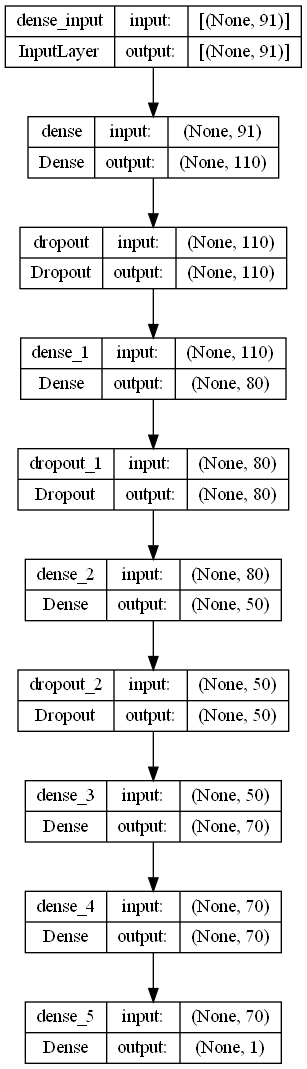

In [10]:
plot_model(model_complex, show_shapes=True, show_layer_names=True)